# Advanced Computer Vision

# Part 1

## Context:
Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to
automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information
button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from
screen shots from the movie scene.

## Data Description:
The dataset comprises of images and its mask where there is a human face.

## Project Objective:
Face detection from training images

## Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from matplotlib import pyplot
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Reshape

## Settings

In [ ]:
# Set the random seet
np.random.seed(1)

In [ ]:
tf.random.set_seed(1)

## Load the Images with Boundary Box Details

In [ ]:
data = np.load('/content/drive/MyDrive/Colab Notebooks/Advanced_CNN/ACV_Proj/Dataset- Images.npy',allow_pickle = True)

In [ ]:
data.shape

(409, 2)

**Observation:**
- There are 409 images.

In [ ]:
print(data[0])

[array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)
 list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.306306

In [ ]:
 # Split the train and test set
 X_train, X_test, y_train, y_test = train_test_split(data, list(range(len(data))), test_size=0.10, random_state=50)

In [ ]:
# Verify the boundry box details
X_train[0][1]

[{'imageHeight': 588,
  'imageWidth': 736,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.375, 'y': 0.14625850340136054},
   {'x': 0.4986413043478261, 'y': 0.3979591836734694}]},
 {'imageHeight': 588,
  'imageWidth': 736,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6100543478260869, 'y': 0.28401360544217685},
   {'x': 0.7649456521739131, 'y': 0.48299319727891155}]}]

In [ ]:
X_test.shape

(41, 2)

#### Initialize the Image Size

In [ ]:
IMG_WIDTH = 224   
IMG_HEIGHT = 224

## Data Prepration with Mask

In [ ]:
# Defin the function to split the image and mask. 
def data_prep(imgdata,IMG_HEIGHT,IMG_WIDTH):
  masks = np.zeros((int(imgdata.shape[0]), IMG_HEIGHT, IMG_WIDTH))
  train_data = np.zeros((int(imgdata.shape[0]), IMG_HEIGHT, IMG_WIDTH, 3))

  for index in range(imgdata.shape[0]):
    img = imgdata[index][0]
    img = cv2.resize(img, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
        continue
    train_data[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in imgdata[index][1]:
        x1 = int(i["points"][0]['x'] * IMG_WIDTH)
        x2 = int(i["points"][1]['x'] * IMG_WIDTH)
        y1 = int(i["points"][0]['y'] * IMG_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMG_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1
  return train_data, masks

In [ ]:
# Get the image and mask details for training data
trn_data, trn_masks = data_prep(X_train,IMG_HEIGHT,IMG_WIDTH)

In [ ]:
trn_data.shape

(368, 224, 224, 3)

In [ ]:
trn_masks.shape

(368, 224, 224)

In [ ]:
test_data, test_masks = data_prep(X_test,IMG_HEIGHT,IMG_WIDTH)

In [ ]:
test_data.shape

(41, 224, 224, 3)

In [ ]:
test_masks.shape

(41, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


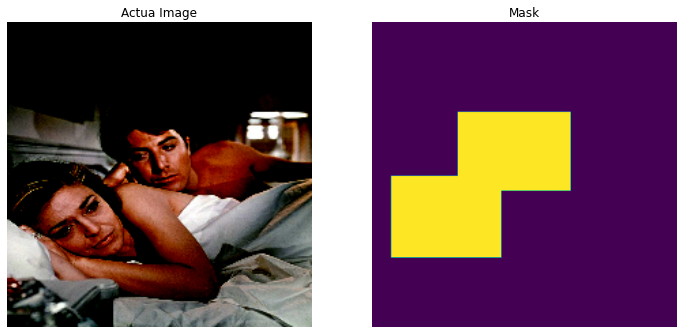

In [ ]:
# Verify the sample image and mask
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))
ax1.set_title('Actua Image')
ax1.imshow(trn_data[99], interpolation = 'bilinear')
ax1.axis('off')
ax2.set_title('Mask')
ax2.imshow(trn_masks[99],  interpolation = 'bilinear')
ax2.axis('off')
plt.show()

## Model Building using Transfer Learning with U-Net

### Load VGG16 Pre-trained model

In [ ]:
# Load VGG16 Pre-trained model
model = VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False,  weights="imagenet")

for layer in model.layers:
        layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Print VGG16 structure
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.get_layer(index=0)

### Build the U-net along with VGG16

In [ ]:
# Build U-net along with pre-trained model
# the bridge (exclude the last maxpooling layer in VGG16) 
bridge = model.get_layer("block5_conv3").output
print(bridge.shape)

# Decoder now
up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
print(up1.shape)
concat_1 = concatenate([up1, model.get_layer("block4_conv3").output], axis=3)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
#conv6 = BatchNormalization()(conv6)
#conv6 = Dropout(0.3)(conv6)

up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
print(up2.shape)
concat_2 = concatenate([up2, model.get_layer("block3_conv3").output], axis=3)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
#conv7 = BatchNormalization()(conv7)
#conv7 = Dropout(0.3)(conv7)

up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
print(up3.shape)
concat_3 = concatenate([up3, model.get_layer("block2_conv2").output], axis=3)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
#conv8 = BatchNormalization()(conv8)
#conv8 = Dropout(0.3)(conv8)

up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
print(up4.shape)
concat_4 = concatenate([up4, model.get_layer("block1_conv2").output], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
#conv9 = BatchNormalization()(conv9)
#conv9 = Dropout(0.3)(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
print(conv10.shape)

modelunet = Model(inputs=[model.input], outputs=[conv10])

(None, 14, 14, 512)
(None, 28, 28, 512)
(None, 56, 56, 256)
(None, 112, 112, 128)
(None, 224, 224, 64)
(None, 224, 224, 1)


In [ ]:
# Print U-net structure
modelunet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

### Skeleton of U-net with VGG16

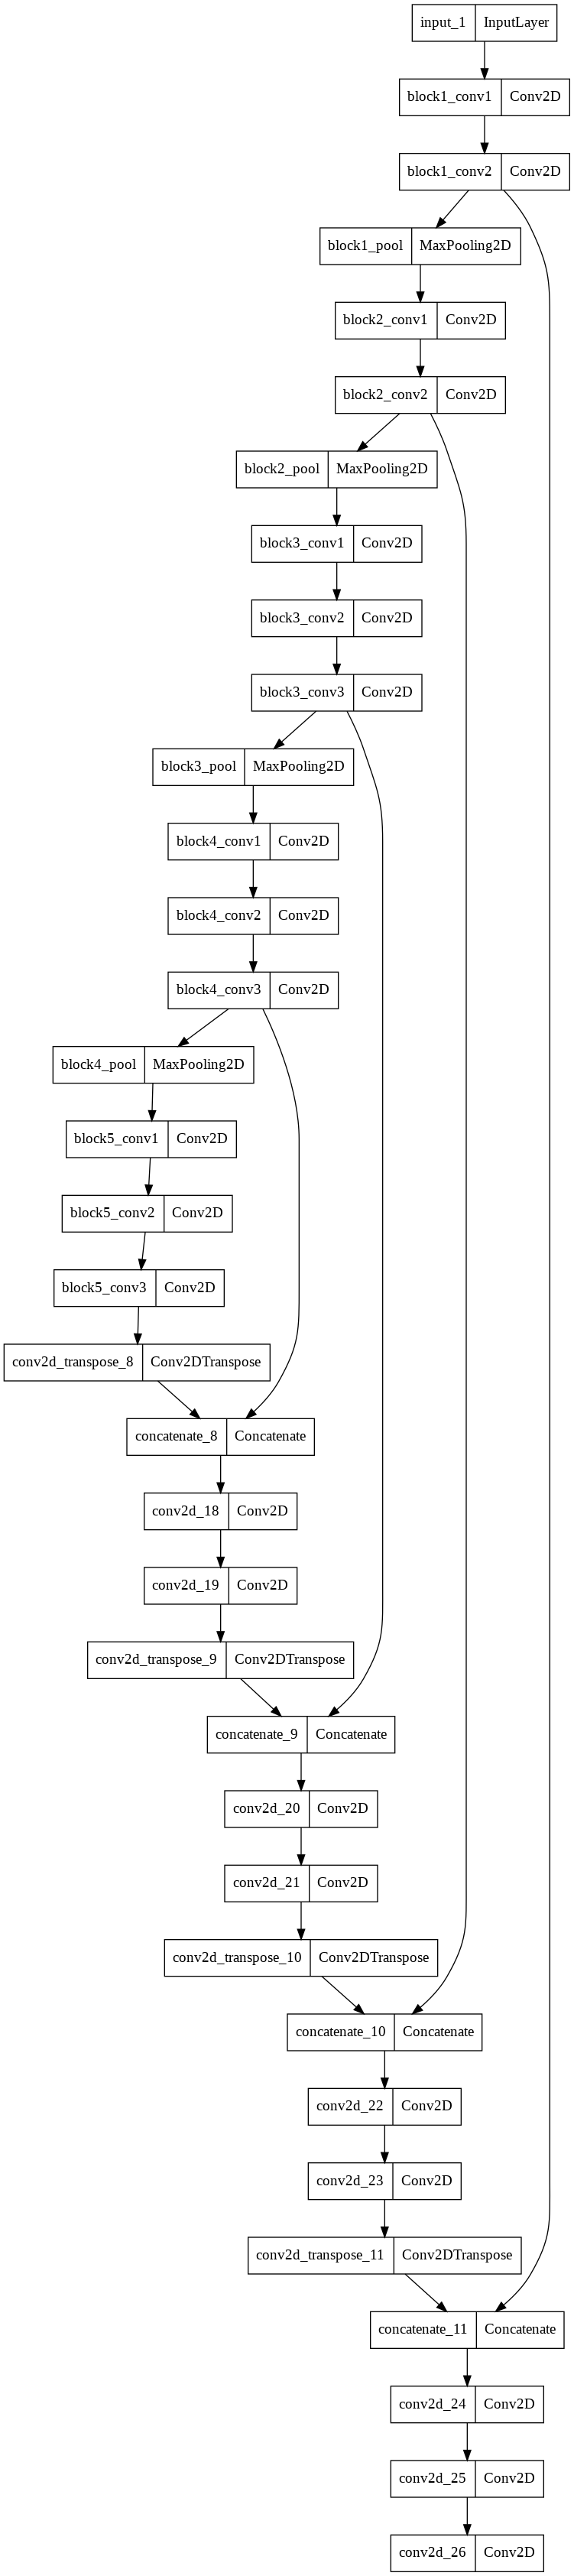

In [ ]:
# Plot the model to view the skeleton 
tf.keras.utils.plot_model(
    modelunet, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

### Dice Coefficient

In [ ]:
# Define the function for calculating dice cofficient
def dice_coefficient(y_true, y_pred):
    #### code added below ####
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Loss Function

In [ ]:
# Define the function for calculating loss
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

# Compile and Train the Model

In [ ]:
# Compile the model with Adam optimizer
#optimizer = RMSprop(lr=0.001)
optimizer = Adam(lr=1e-4, beta_1=0.999, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
modelunet.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Train the model
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
history = modelunet.fit(  trn_data,trn_masks,
                          validation_data=(test_data, test_masks), 
                          epochs=50,
                          batch_size = 5, 
                          verbose=1
                          #callbacks= [callback]
                        )

Epoch 1/50
74/74 [==============================] - 9s 94ms/step - loss: 1.6182 - dice_coefficient: 0.3598 - val_loss: 1.0111 - val_dice_coefficient: 0.6229
Epoch 2/50
74/74 [==============================] - 7s 88ms/step - loss: 0.9899 - dice_coefficient: 0.5615 - val_loss: 0.7983 - val_dice_coefficient: 0.5952
Epoch 3/50
74/74 [==============================] - 7s 88ms/step - loss: 0.8182 - dice_coefficient: 0.6066 - val_loss: 0.7495 - val_dice_coefficient: 0.6319
Epoch 4/50
74/74 [==============================] - 7s 88ms/step - loss: 0.7711 - dice_coefficient: 0.6184 - val_loss: 0.7261 - val_dice_coefficient: 0.6304
Epoch 5/50
74/74 [==============================] - 7s 88ms/step - loss: 0.7252 - dice_coefficient: 0.6290 - val_loss: 0.7980 - val_dice_coefficient: 0.6463
Epoch 6/50
74/74 [==============================] - 7s 88ms/step - loss: 0.7044 - dice_coefficient: 0.6500 - val_loss: 0.7194 - val_dice_coefficient: 0.6465
Epoch 7/50
74/74 [==============================] - 7s 88m

### Model Evaluation

In [ ]:
# Evaluate the model
modelunet.evaluate(test_data, test_masks)

2/2 [==============================] - 0s 68ms/step - loss: 1.0062 - dice_coefficient: 0.7036


[1.00617253780365, 0.7036134004592896]

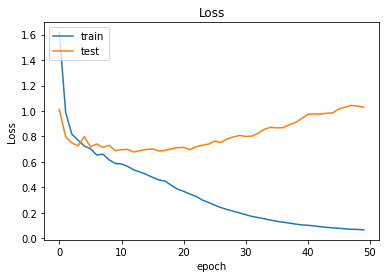

In [ ]:
# Plot the graph for Loss vs Val Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Observation:**
-Loss for test set is higher than training set loss.

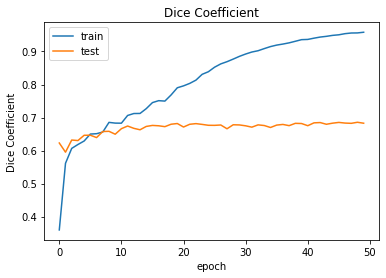

In [ ]:
# Plot the graph for Dice Coefficient vs Val Dice Coefficient
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Obsrvation:**
- Above graph shows that dice coefficient value of test set is 0.6229 in 1st epoch and slowly increased to 0.6828 in last epoch while the dice coefficient value of training set is 0.9583 in last epoch.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


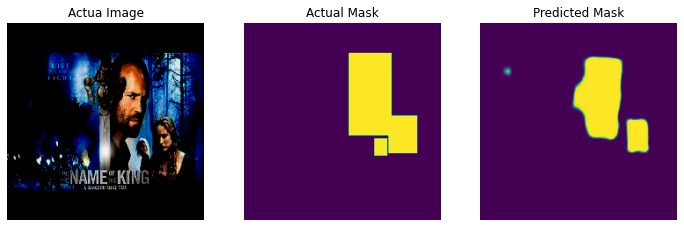

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


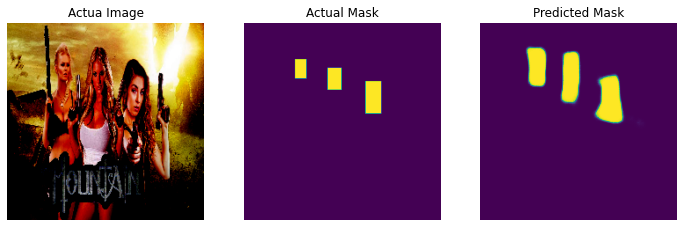

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


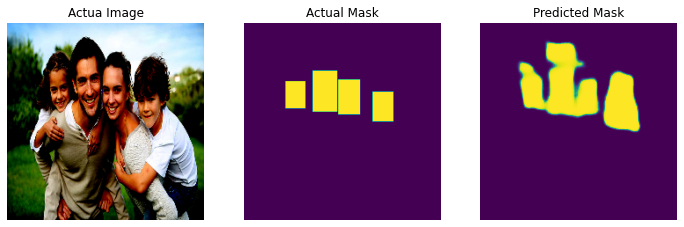

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


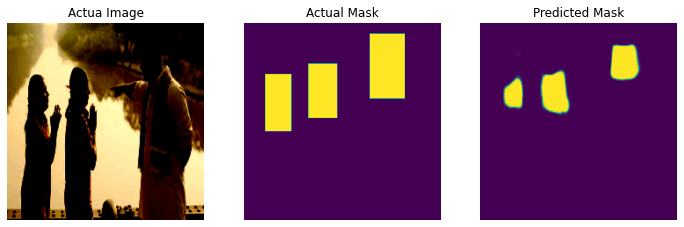

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


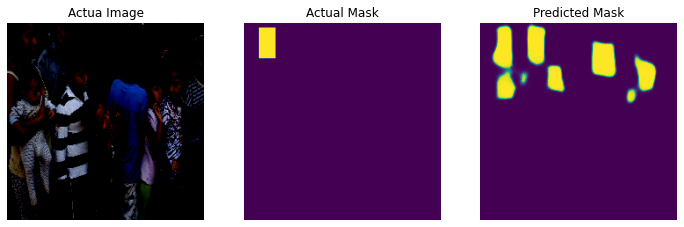

In [ ]:
# Test the model with sample images
#fig, (ax1, ax2, ax3) = plt.subplots(11, 3, figsize = (12, 8))
for i in range(5):
  n = random.randint(0,len(test_data))
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))
  ax1.set_title('Actua Image')
  ax1.imshow(test_data[n], interpolation = 'bilinear')
  ax1.axis('off')
  ax2.set_title('Actual Mask')
  ax2.imshow(test_masks[n],  interpolation = 'bilinear')
  ax2.axis('off')
  ax3.set_title('Predicted Mask')
  ax3.imshow(modelunet.predict(test_data[n].reshape(1,224,224,3)).reshape(224,224),  interpolation = 'bilinear')
  ax3.axis('off')
  plt.show()


## Predict the mask for given image

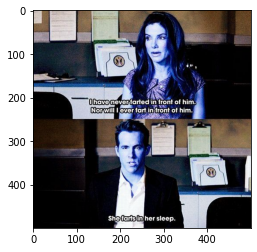

In [ ]:
# Load the image
filename = '/content/drive/MyDrive/Colab Notebooks/Advanced_CNN/ACV_Proj/Prediction_Image.jpeg'
unscaled = cv2.imread(filename) # Original image for display
plt.imshow(unscaled)


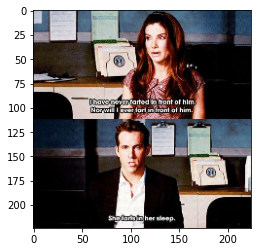

In [ ]:
# Resize the image
img_x = cv2.imread(filename)
img_x = cv2.cvtColor(img_x, cv2.COLOR_BGR2RGB)
img_x = cv2.resize(img_x,(224,224))
plt.imshow(img_x)
#act_img = img_x.reshape(1,224,224,3)

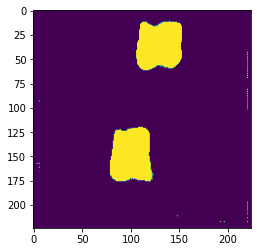

In [ ]:
# Predict the mask using the model for above image
a=modelunet.predict(img_x.reshape(1,224,224,3))
pyplot.imshow(a.reshape(224,224)) 
pyplot.show()

**Observation:**
- This model is overfit since training set loss (0.0665) is lower than test set loss (1.0295). The variation between traing and test is high Similarly, dice coefficient value of training set is 0.9583 and  dice coefficient value of test set is 0.6828. 
- Dice coefficient for over all model is 0.7036

# Part 2

## Context:
Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company
wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast
information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to
detect faces from screen shots from the movie scene.

## Task:
Help to create an image dataset to be used by the AI team to build an image classifier data. Profile images of people are given.

## Import Libraries

In [2]:
!pip install face-recognition pillow

     |████████████████████████████████| 100.1 MB 35 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=6ba7d871d06a39c120e9ebc3468e8fb5596f84ced05f6a05832e5c1bb816950e
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [3]:
import cv2
from PIL import *
from PIL import Image, ImageDraw, ImageFont
import face_recognition
import os
import pandas as pd
import matplotlib.patches as patches
from matplotlib import pyplot
import matplotlib.pyplot as plt


## Find the Boundary Co-ordinates

In [4]:

folder = "/content/drive/MyDrive/Colab Notebooks/Advanced_CNN/ACV_Proj/training_images" 

xmin = []
xmax = []
ymin = []
ymax = []
width = []
height = []
numberofface = []
image_name = []
for filename in os.listdir(folder):
  
  #img = cv2.imread(os.path.join(folder,filename))
  image = face_recognition.load_image_file(os.path.join(folder,filename))
  face_locations = face_recognition.face_locations(image,  model='cnn')
  print(filename)
  print("Found {} faces in this photograph.".format(len(face_locations)))
  pil_image = Image.fromarray(image)
  if len(face_locations) > 0:
      # Extract bounding box points for all detected faces in image
      for face_location in face_locations:
          # Print the location of each face in this image
          top, right, bottom, left = face_location
        
          # Draw a rectangle using ImageDraw function on image
          shape = [(left, top), (right, bottom)] 
          xmin.append(left)
          xmax.append(right)
          ymin.append(top)
          ymax.append(bottom)
          height.append(bottom - top)
          width.append(right - left)
          numberofface.append(len(face_locations))
          image_name.append(filename)
          #print(shape)
          img1 = ImageDraw.Draw(pil_image)   
        
          # We set outline color as red and width of 4
          img1.rectangle(shape, outline ="red", width=4) 
          # Show final image
          pil_image.show()
          # Save image
          outputimgname = "/content/drive/MyDrive/Colab Notebooks/Advanced_CNN/ACV_Proj/Part2-Output/output_"+filename
          #print(outputimgname)
          pil_image.save(outputimgname)
  else:
          outputimgname = "/content/drive/MyDrive/Colab Notebooks/Advanced_CNN/ACV_Proj/Part2-Output-Failed/output_"+filename
          pil_image.save(outputimgname)
  

real_00045.jpg
Found 1 faces in this photograph.
real_00035.jpg
Found 1 faces in this photograph.
real_00147.jpg
Found 1 faces in this photograph.
real_00075.jpg
Found 1 faces in this photograph.
real_00134.jpg
Found 1 faces in this photograph.
real_00044.jpg
Found 1 faces in this photograph.
real_00166.jpg
Found 1 faces in this photograph.
real_00039.jpg
Found 1 faces in this photograph.
real_00036.jpg
Found 1 faces in this photograph.
real_00093.jpg
Found 1 faces in this photograph.
real_00057.jpg
Found 1 faces in this photograph.
real_00092.jpg
Found 1 faces in this photograph.
real_00055.jpg
Found 1 faces in this photograph.
real_00091.jpg
Found 1 faces in this photograph.
real_00095.jpg
Found 1 faces in this photograph.
real_00151.jpg
Found 1 faces in this photograph.
real_00109.jpg
Found 1 faces in this photograph.
real_00136.jpg
Found 1 faces in this photograph.
real_00143.jpg
Found 1 faces in this photograph.
real_00028.jpg
Found 1 faces in this photograph.
real_00104.jpg
Found

## Save the Boundary Co-ordinates

In [5]:
data = {'image_name':image_name,
        'xmin':xmin,
        'xmax':xmax,
        'ymin':ymin,
        'ymax':ymax,
        'width':width,
        'height':height,
        'total_faces':numberofface}

  # Create DataFrame
df = pd.DataFrame(data)
df.to_csv("image_boudaries.csv")  
# Print the output.
df.head()

,image_name,xmin,xmax,ymin,ymax,width,height,total_faces
0,real_00045.jpg,105,457,159,511,352,352,1
1,real_00035.jpg,158,451,229,522,293,293,1
2,real_00147.jpg,175,597,105,528,422,423,1
3,real_00075.jpg,34,386,159,511,352,352,1
4,real_00134.jpg,105,457,159,511,352,352,1


In [6]:
df.shape

(1098, 8)

## Validation

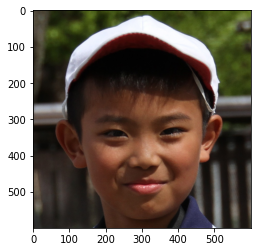

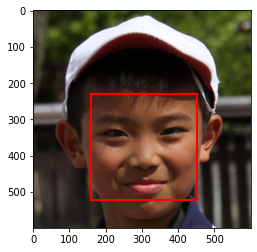

In [8]:
filename = "/content/drive/MyDrive/Colab Notebooks/Advanced_CNN/ACV_Proj/training_images/real_00035.jpg"

unscaled = cv2.imread(filename) # Original image for display
unscaled = cv2.cvtColor(unscaled, cv2.COLOR_BGR2RGB)
plt.imshow(unscaled)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((df['xmin'][1], df['ymin'][1]), df['width'][1] , df['height'][1] , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## Challenges

- Used face-recognition packaged to find the coordinates. 
- Not able to find the boundaries for 72 images due to black faces, dull, blur and more bright images. 
- Changed the parameter model='hog' to model='cnn' and identified coordinates for all the images. 
- For few images, face edges are not detecting properly. To resolve this,  tried with multiple values for number_of_times_to_upsample but RAM size is not supporting in GPU. 

# End Project